In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
S, P = np.load("butadien/dataset.npy")
molecules = np.load("butadien/molecules.npy")

In [3]:
from SCFInitialGuess.utilities.dataset import Dataset

dim = 26

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_test = np.array(S)[index[150:]]
P_test = np.array(P)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S)[index[:150]]
P_train = np.array(P)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-03-22 16:42:14: Data set initialized. Mean value std: 0.008772604537482114


# Training different costs

In [4]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=RegularizedMSE(alpha=1e-7)
)

trainer.setup()
network_orig, sess_orig = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph_orig = trainer.graph

[-] 2018-03-22 16:42:14: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-22 16:42:14: Setting up the training in the target graph ...
[-] 2018-03-22 16:42:14: network ...
[-] 2018-03-22 16:42:14: error function ...
[-] 2018-03-22 16:42:15: cost function ...
[-] 2018-03-22 16:42:24: training step
[-] 2018-03-22 16:42:24: Starting network training ...
[ ] 2018-03-22 16:42:24: Validation cost: 5.77705E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-22 16:42:25: Validation cost: 2.14789E-04. Diff to prev.: 5.8E-02
[ ] 2018-03-22 16:42:26: Validation cost: 1.17880E-04. Diff to prev.: 9.7E-05
[ ] 2018-03-22 16:42:27: Validation cost: 1.00469E-04. Diff to prev.: 1.7E-05
[ ] 2018-03-22 16:42:28: Validation cost: 8.86332E-05. Diff to prev.: 1.2E-05
[ ] 2018-03-22 16:42:28: Validation cost: 9.17811E-05. Diff to prev.: 3.1E-06
[ ] 2018-03-22 16:42:30: Validation cost: 7.84969E-05. Diff to prev.: 1.3E-05
[ ] 2018-03-22 16:42:30: Validation cost: 6.85210E-05. Diff to prev.: 

### Check symmetry

0.0007466


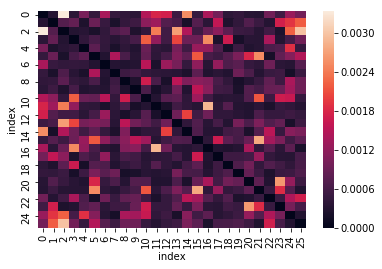

In [6]:
from SCFInitialGuess.utilities.plotutils import matrix_error

with graph_orig.as_default():
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))

plt.show()

0.977433


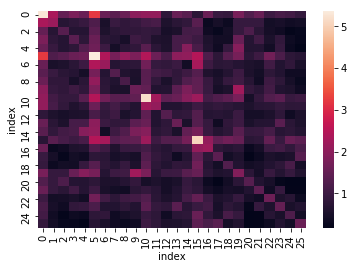

In [7]:
from SCFInitialGuess.utilities.plotutils import matrix_error

def idempotency_error(network):
    p = tf.reshape(network.output_tensor, [-1, dim, dim])
    s = tf.reshape(network.input_tensor, [-1, dim, dim])
    
    lhs = tf.matmul(tf.matmul(p, s), p)
    rhs = 2 * p
    return tf.reduce_mean(tf.abs(lhs - rhs), axis=0)

with graph_orig.as_default():
    
    
    """
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    squared = tf.matmul(reshaped, reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - squared), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    """
    error = sess_orig.run(
        idempotency_error(network_orig),
       {network_orig.input_tensor: dataset.testing[0]}
    )
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()

## Enforce hermiticity

In [8]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class SymmetryPenalty(MSE):
    def __init__(self, coupling=1e-4):
        """alpha: coupling parameter"""
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(SymmetryPenalty, self).function(network, y_placeholder)

        penalty = self.symmetry_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def symmetry_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        transposed = tf.matrix_transpose(reshaped)
        return tf.reduce_mean(tf.norm(reshaped - transposed, axis=(1,2))**2 )

    
trainer_sym = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=SymmetryPenalty(coupling=5e-2)
)

trainer_sym.setup()
network_sym, sess_sym = trainer_sym.train(
    dataset,
    convergence_threshold=1e-6
)
graph_sym = trainer_sym.graph
        

[-] 2018-03-22 16:43:38: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-22 16:43:38: Setting up the training in the target graph ...
[-] 2018-03-22 16:43:38: network ...
[-] 2018-03-22 16:43:38: error function ...
[-] 2018-03-22 16:43:38: cost function ...
[-] 2018-03-22 16:43:38: training step
[-] 2018-03-22 16:43:39: Starting network training ...
[ ] 2018-03-22 16:43:39: Validation cost: 5.76823E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-22 16:43:40: Validation cost: 4.55078E-04. Diff to prev.: 5.7E-02
[ ] 2018-03-22 16:43:41: Validation cost: 7.59961E-04. Diff to prev.: 3.0E-04
[ ] 2018-03-22 16:43:42: Validation cost: 4.39429E-04. Diff to prev.: 3.2E-04
[ ] 2018-03-22 16:43:43: Validation cost: 4.79652E-04. Diff to prev.: 4.0E-05
[ ] 2018-03-22 16:43:44: Validation cost: 3.11965E-04. Diff to prev.: 1.7E-04
[ ] 2018-03-22 16:43:45: Validation cost: 3.03239E-04. Diff to prev.: 8.7E-06
[ ] 2018-03-22 16:43:46: Validation cost: 2.99742E-04. Diff to prev.: 

0.000362718


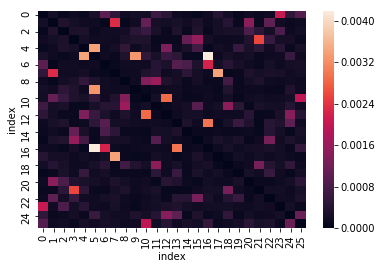

In [9]:
with graph_sym.as_default():
    reshaped = tf.reshape(network_sym.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_sym.run(diff_mean, {network_sym.input_tensor: dataset.testing[0]})
    matrix_error(error)
    print(np.mean(error))

plt.show()

## Enforce idempotency

In [26]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class IdempotencyPenalty(MSE):
    def __init__(self, coupling=1e-4):
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(IdempotencyPenalty, self).function(network, y_placeholder)

        penalty = self.idempotency_error(network) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def idempotency_error(self, network):
        p = tf.reshape(network.output_tensor, [-1, dim, dim])
        s = tf.reshape(network.input_tensor, [-1, dim, dim])

        lhs = tf.matmul(tf.matmul(p, s), p)
        rhs = 2 * p
        return tf.reduce_mean(tf.norm(tf.abs(lhs - rhs), axis=(1,2)) **2 )

try:
    del graph_idem
except:
    pass
    
trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=IdempotencyPenalty(coupling=1e-5)
)

trainer.setup()
network_idem, sess_idem = trainer.train(
    dataset,
    convergence_threshold=3e-6,
    summary_save_path="log2/idem"
)
graph_idem = trainer.graph

[-] 2018-03-22 17:49:16: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-22 17:49:16: Setting up the training in the target graph ...
[-] 2018-03-22 17:49:16: network ...
[-] 2018-03-22 17:49:16: error function ...
[-] 2018-03-22 17:49:16: cost function ...
[-] 2018-03-22 17:49:16: training step
[-] 2018-03-22 17:49:16: Starting network training ...
[ ] 2018-03-22 17:49:16: Validation cost: 5.78458E-02. Diff to prev.: 1.0E+10
[ ] 2018-03-22 17:49:18: Validation cost: 2.52557E-03. Diff to prev.: 5.5E-02
[ ] 2018-03-22 17:49:19: Validation cost: 2.36475E-03. Diff to prev.: 1.6E-04
[ ] 2018-03-22 17:49:21: Validation cost: 2.38036E-03. Diff to prev.: 1.6E-05
[ ] 2018-03-22 17:49:23: Validation cost: 2.36061E-03. Diff to prev.: 2.0E-05
[ ] 2018-03-22 17:49:25: Validation cost: 2.38321E-03. Diff to prev.: 2.3E-05
[ ] 2018-03-22 17:49:26: Validation cost: 2.42279E-03. Diff to prev.: 4.0E-05
[ ] 2018-03-22 17:49:28: Validation cost: 2.34938E-03. Diff to prev.: 

0.532079


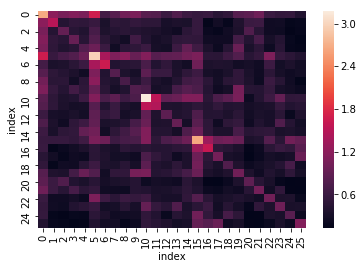

In [27]:
with graph_idem.as_default():
    error = sess_idem.run(idempotency_error(network_idem), {network_idem.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()
    
    

# Analysis

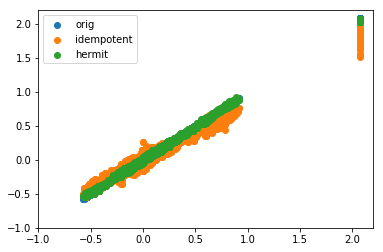

In [28]:
with graph_orig.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_orig.run(sess_orig, dataset.testing[0]),
        label="orig"
    )
    
with graph_idem.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_idem.run(sess_idem, dataset.testing[0]),
        label="idempotent"
    )
    

with graph_sym.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_sym.run(sess_sym, dataset.testing[0]),
        label="hermit"
    )

#lower = 1.8
lower = -1
upper = 2.2
plt.xlim([lower, upper])
plt.ylim([lower, upper])
    

plt.legend()
plt.show()

In [29]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.plotutils import prediction_scatter

dim = 26

iterations = []
for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    # nn guess
    s = hf.get_ovlp(mol).reshape(1, dim**2)
    s = Dataset.normalize(s, mean=dataset.x_mean, std=dataset.x_std)[0]
    
    with graph_orig.as_default():
        P_orig = network_orig.run(sess_orig, s).reshape(dim, dim).astype('float64')
        
    with graph_idem.as_default():
        P_idem = network_idem.run(sess_idem, s).reshape(dim, dim).astype('float64')
    
    with graph_sym.as_default():
        P_sym = network_sym.run(sess_sym, s).reshape(dim, dim).astype('float64')
    
    
    # P_actual wi noise
    p_noise = p.reshape(dim, dim) + np.random.randn(dim, dim) * 1e-4
    
    
    iterations_molecule = []
    for guess in [p_noise, P_orig, P_idem, P_sym]:
        
        mf = hf.RHF(mol)
        mf.diis = None
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations_molecule.append(mf.iterations)
    
    iterations.append(iterations_molecule)

iterations = np.array(iterations)

Warn: Ipython shell catchs sys.args


Calculating: 1/50


Warn: Ipython shell catchs sys.args


Calculating: 2/50


Warn: Ipython shell catchs sys.args


Calculating: 3/50


Warn: Ipython shell catchs sys.args


Calculating: 4/50


Warn: Ipython shell catchs sys.args


Calculating: 5/50


Warn: Ipython shell catchs sys.args


Calculating: 6/50


Warn: Ipython shell catchs sys.args


Calculating: 7/50


Warn: Ipython shell catchs sys.args


Calculating: 8/50


Warn: Ipython shell catchs sys.args


Calculating: 9/50


Warn: Ipython shell catchs sys.args


Calculating: 10/50


Warn: Ipython shell catchs sys.args


Calculating: 11/50


Warn: Ipython shell catchs sys.args


Calculating: 12/50


Warn: Ipython shell catchs sys.args


Calculating: 13/50


Warn: Ipython shell catchs sys.args


Calculating: 14/50


Warn: Ipython shell catchs sys.args


Calculating: 15/50


Warn: Ipython shell catchs sys.args


Calculating: 16/50


Warn: Ipython shell catchs sys.args


Calculating: 17/50


Warn: Ipython shell catchs sys.args


Calculating: 18/50


Warn: Ipython shell catchs sys.args


Calculating: 19/50


Warn: Ipython shell catchs sys.args


Calculating: 20/50


Warn: Ipython shell catchs sys.args


Calculating: 21/50


Warn: Ipython shell catchs sys.args


Calculating: 22/50


Warn: Ipython shell catchs sys.args


Calculating: 23/50


Warn: Ipython shell catchs sys.args


Calculating: 24/50


Warn: Ipython shell catchs sys.args


Calculating: 25/50


Warn: Ipython shell catchs sys.args


Calculating: 26/50


Warn: Ipython shell catchs sys.args


Calculating: 27/50


Warn: Ipython shell catchs sys.args


Calculating: 28/50


Warn: Ipython shell catchs sys.args


Calculating: 29/50


Warn: Ipython shell catchs sys.args


Calculating: 30/50


Warn: Ipython shell catchs sys.args


Calculating: 31/50


Warn: Ipython shell catchs sys.args


Calculating: 32/50


Warn: Ipython shell catchs sys.args


Calculating: 33/50


Warn: Ipython shell catchs sys.args


Calculating: 34/50


Warn: Ipython shell catchs sys.args


Calculating: 35/50


Warn: Ipython shell catchs sys.args


Calculating: 36/50


Warn: Ipython shell catchs sys.args


Calculating: 37/50


Warn: Ipython shell catchs sys.args


Calculating: 38/50


Warn: Ipython shell catchs sys.args


Calculating: 39/50


Warn: Ipython shell catchs sys.args


Calculating: 40/50


Warn: Ipython shell catchs sys.args


Calculating: 41/50


Warn: Ipython shell catchs sys.args


Calculating: 42/50


Warn: Ipython shell catchs sys.args


Calculating: 43/50


Warn: Ipython shell catchs sys.args


Calculating: 44/50


Warn: Ipython shell catchs sys.args


Calculating: 45/50


Warn: Ipython shell catchs sys.args


Calculating: 46/50


Warn: Ipython shell catchs sys.args


Calculating: 47/50


Warn: Ipython shell catchs sys.args


Calculating: 48/50


Warn: Ipython shell catchs sys.args


Calculating: 49/50


Warn: Ipython shell catchs sys.args


Calculating: 50/50


In [30]:
print(np.mean(iterations,0))

[  5.56  13.84  21.1   15.82]


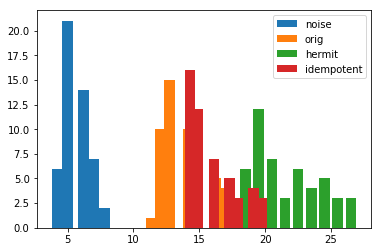

In [31]:

bins = 20 # todo hier kann man auch ein array angeben

for i, name in enumerate(['noise', 'orig', 'hermit', 'idempotent']):
    
    hist, bins = np.histogram(iterations[:,i])
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=name)
    
plt.legend()
plt.show()